# Camera CMFs recovery process
This notebook shows how to recover the CMFs for a camera using a set of photos and their accompanying spectra. 

## Software requierements

- The module colourscience (conda install -c conda-forge colour-science)
- The module tqdm for showing progress bars
- The module joblib for parallel processing of the samples

## Data requirements

A set of photos of uniform colors and their accompanying measured spectra. The spectra should be in csv or text format in two columns, wavelenght and intensity. All samples should be photographed under the same illumination, exposure and white balance. All sample spectra should have the same integration time. Photos and spectra should have the same filename, e.g.

- A1.tif, A_reflection_1.txt
- A2.tif, A_reflection_2.txt
- A3.tif, A_reflection_3.txt


### Note about bit depth

The Thorlabs color CCD is capable of capturing images with up to 14 bits per color channel, however, because of how it was programmed the Thorcam software saves the files as 16 bit tiff photos without rescaling the channels. When opened in any photo viewer other than Thorcam the images will look dark (1/4 the real brightness to be exact) as only the first 14 bits of each channel contain information. So that they can be correctly visualized the values in each color channel need to be multiplied by 4. For slightly higher precision the file can be opened in 16 bit mode and then its values divided by $2^{14}$ for rescaling to [0-1]

## Theory

Altough its exact operation is different, we can think of a camera as operating similarly to the human visual system in that it "sees" a spectra and maps it to a triplet of numbers (RGB values) everytime a picture is taken. The RGB values can be seen as the result of the operations:

$R=\int_{\lambda_0}^{\lambda_f} P(\lambda)r(\lambda)d\lambda$, $G=\int_{\lambda_0}^{\lambda_f} P(\lambda)g(\lambda)d\lambda$, $B=\int_{\lambda_0}^{\lambda_f} P(\lambda)b(\lambda)d\lambda$

where $r(\lambda), g(\lambda), b(\lambda)$ are the color matching functions (CMFs) of the camera. To recover the CMFs we write them in terms of a series expansion, eg. 

$$r(\lambda)=\sum_{n=1}^N k_n exp\left[-\frac{(\lambda-\lambda_n)^2}{\sigma^2}\right]$$

Substituting into the expression for R and unsing linearity to rearrange we get:

$$ R=\sum_{n=1}^N k_n \int_{\lambda_0}^{\lambda_f} P(\lambda)exp\left[-\frac{(\lambda-\lambda_n)^2}{\sigma^2}\right]$$


Linear regression can now be used to recover the coefficients $k_n$ and therefore the CMFs. The problem is equivalent to finding the vector $x$ that minimizes the inequality in the expression:

$$Ax\approx b$$

where each row of $A$ is contains the result of the intergrals for a single spectrum, $x$ are the coefficients $k_n$, and $b$ are the real R values.

**Note**: Because the RGB values must always be positive the base functions and coefficients must always be chosen to be positive. Non-negative linear regression is required to solve the problem.



**Made 09/02/2020 by Arturo Burguete Lopez**


### Import dependencies and locate data

In [1]:
import os
import re  # Regular expressions support

import colour
import imageio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import scipy
from joblib import Parallel, delayed
from scipy.signal import savgol_filter
from tqdm import tqdm  # Show progress bars

# === Readable font size in plots == #

# plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams.update({"font.size": 14})
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42

# ==== User selected parameters === #

# Directory with photos and spectra for the color samples
sampledir = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Camera calibration/"
spectra_ext = ".txt"
photo_ext = ".tif"

# Wavelength range for spectra
lam0 = 400
lamf = 700

lams = np.arange(lam0, lamf + 1)

# Spectra noise reduction
filt_win = 21  # Filter window (must be even)
filt_pol = 3  # Filter interpolating polymonial

# Photo cropping
crop_factor = 0.85  # [0-1] Takes only a fraction of the photo from the center to remove vignetting effects

# Training set selection
train_percent = 0.75  # Percent of all samples to use for training

### Define the Sample class

For convenience we define a class to hold the information of the spectra and RGB values of each sample

In [2]:
class Sample:
    """ This class stores and processes the experimental data of a sample
    
        Attributes:
            - name [str] : Name of the sample
            - raw_spectra [1D array]: Intensity values of the sample spectra
            - raw_photo [3D array]: Pixel values of the sample photo        
        Methods:
            - get_raw_spectra(): Returns the raw_spectra
            - get_smooth_spectra(): Returns a filtered version of raw_spectra/mirr_spectra
            - get_cropped_photo(): Returns a cropped version raw_photo
            - get_RGB() : Returns the average RGB values of the photo
            
    """

    def __init__(self, name, spectra, photo):
        # Store the unprocessed data
        self.name = name
        self.raw_spectra = np.interp(lams, spectra[:, 0], spectra[:, 1] / 100)
        self.raw_photo = photo

    def get_smooth_spectra(self, filt_win=filt_win, filt_pol=filt_pol):
        """ Returns a filtered version of the raw_spectra
            
            Arguments:
                - filt_win [odd int]: Number of wavelength points to fit the polynomial on
                - filt_pol [int]: Order of the fitted polynomial
            
            Returns:
                - [1D Array]
        """
        smooth_spectra = savgol_filter(self.raw_spectra, filt_win, filt_pol)
        smooth_spectra[smooth_spectra < 0] = 0
        return smooth_spectra

    def get_cropped_photo(self, crop_factor=crop_factor):
        """ Returns a cropped version of the original photo to remove vignetting
            
            Arguments:
                - crop factor [float, 0-1] Fraction of the photo to use from the center
                
            Returns:
                - [3D Array]
        """
        x, y, _ = self.raw_photo.shape  # Get photo resolution
        cx, cy = int(x * (1 - crop_factor)), int(y * (1 - crop_factor))  # New limits
        return self.raw_photo[cx:-cx, cy:-cy, :]

    def get_RGB(self, crop_factor=crop_factor):
        """ Returns the average RGB values of the cropped photo of the sample
            
            Arguments:
                - crop factor [float, 0-1] Fraction of the photo to use from the center
                
            Returns:
                - [1D array]
        """
        p = self.get_cropped_photo(crop_factor)
        return np.array([p[:, :, 0].mean(), p[:, :, 1].mean(), p[:, :, 2].mean()])

## Load the experimental data

### Obtain samples data and create Sample objects

In [3]:
# Get ordered file list of the sample directory
# key is to sort in alphabetical order as in the file browser
filelist = sorted(
    os.listdir(sampledir),
    key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)],
)

# Obtain the name of the files without extension
photo_file_names = [
    os.path.splitext(file)[0] for file in filelist if file.endswith(photo_ext)
]

# Split photos unto LD and LU lists
LD_photo_files_names = [name for name in photo_file_names if name.endswith("LD")]
LU_photo_files_names = [name for name in photo_file_names if name.endswith("LU")]

# Obtaine name of spectral reflection files
spectra_file_names = [
    os.path.splitext(file)[0] for file in filelist if file.endswith(spectra_ext)
]

# idx = 0
# print(LD_photo_files_names[idx])
# print(LU_photo_files_names[idx])
# print(spectra_file_names[idx])

LD_sample_list = []
print("Loading LD samples")
for q, LDname in enumerate(tqdm(LD_photo_files_names)):
    spectra = np.loadtxt(sampledir + spectra_file_names[q] + spectra_ext, skiprows=14)
    photo = imageio.v2.imread(sampledir + LDname + photo_ext)
    LD_sample_list.append(Sample(LDname, spectra, photo))

LU_sample_list = []
print("Loading LU samples")
for q, LUname in enumerate(tqdm(LU_photo_files_names)):
    spectra = np.loadtxt(sampledir + spectra_file_names[q] + spectra_ext, skiprows=14)
    photo = imageio.v2.imread(sampledir + LUname + photo_ext)
    LU_sample_list.append(Sample(LUname, spectra, photo))

LD_sample_list = np.array(LD_sample_list)
LU_sample_list = np.array(LU_sample_list)

# Select sample kind (LD or LU)
# Theres 50 PMMA samples, 21 A, 30 B. There's also and 15 AZ samples (E).
sample_list = LU_sample_list
# sample_list = LU_sample_list[:51]

Loading LD samples


100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:21<00:00,  2.98it/s]


Loading LU samples


100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:21<00:00,  3.08it/s]


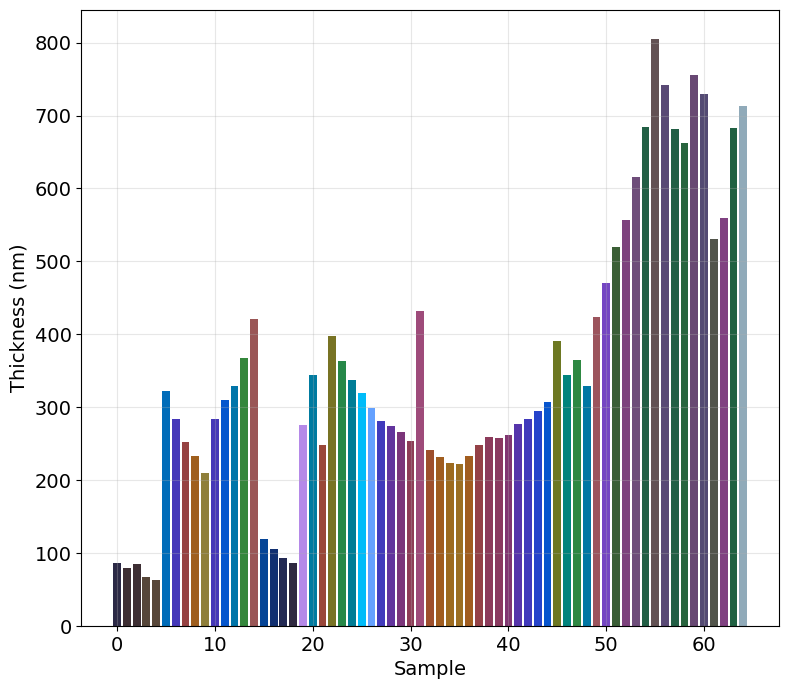

In [10]:
colors=np.array([sample.get_RGB() / 2 ** 14 for sample in LD_sample_list])
colors=colors*1.2
colors[colors>1]=1
meas_thick = np.loadtxt('./Metadata/thickABE.csv', delimiter=",", usecols=1)
plt.figure(figsize=(9,8))
plt.bar(np.arange(meas_thick.size),meas_thick, color=colors)
plt.xlabel('Sample')
plt.ylabel('Thickness (nm)')
plt.grid(True,alpha=0.3)
plt.savefig('./results/sample_thick_bar.pdf',bbox_inches='tight', transparent=True)
plt.show()

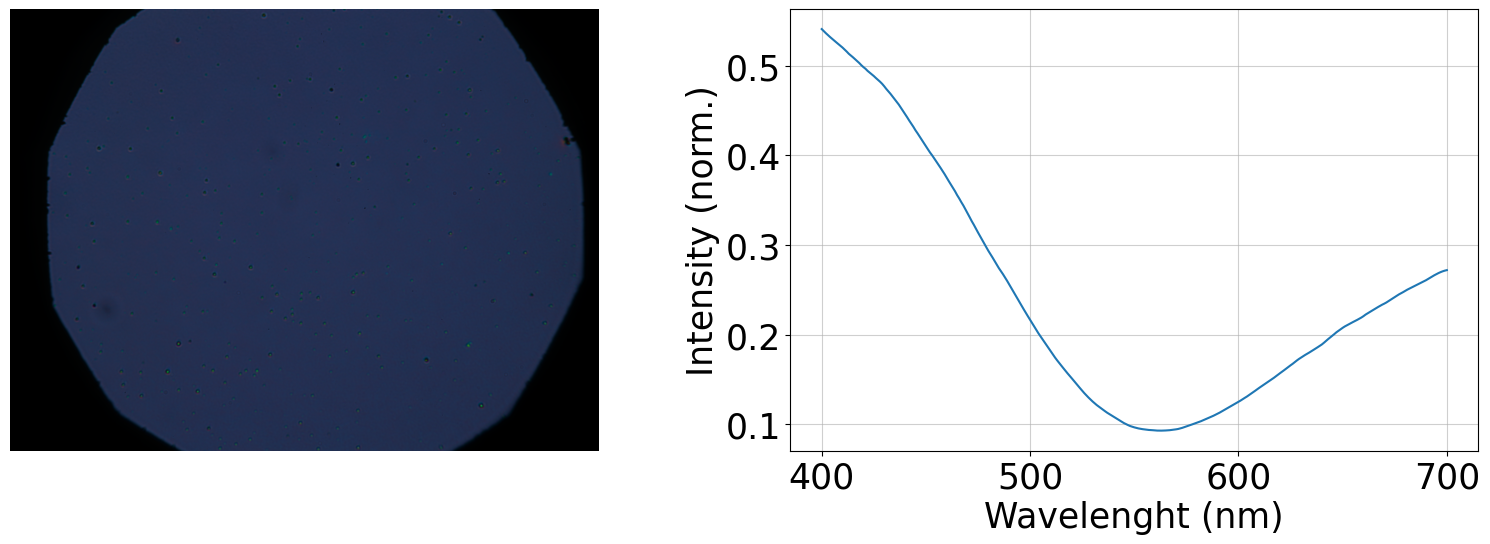

In [5]:
plt.rcParams.update({"font.size": 25})
ran_sam = np.random.choice(sample_list)
# ran_sam = sample_list[7]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(ran_sam.raw_photo / 2 ** 14)
ax[0].axis('off')
# ax[0].set_title("Sample {}, photo".format(ran_sam.name))
ax[1].plot(lams, ran_sam.get_smooth_spectra())
# ax[1].set_title("Reflection spectra".format(ran_sam.name))
ax[1].set_xlabel('Wavelenght (nm)')
ax[1].set_ylabel('Intensity (norm.)')
ax[1].grid(True,alpha=0.6)
plt.tight_layout()
plt.savefig('./results/photo_spec_{}.pdf'.format(ran_sam.name),bbox_inches='tight')
plt.show()

### Example of loaded and processed sample information

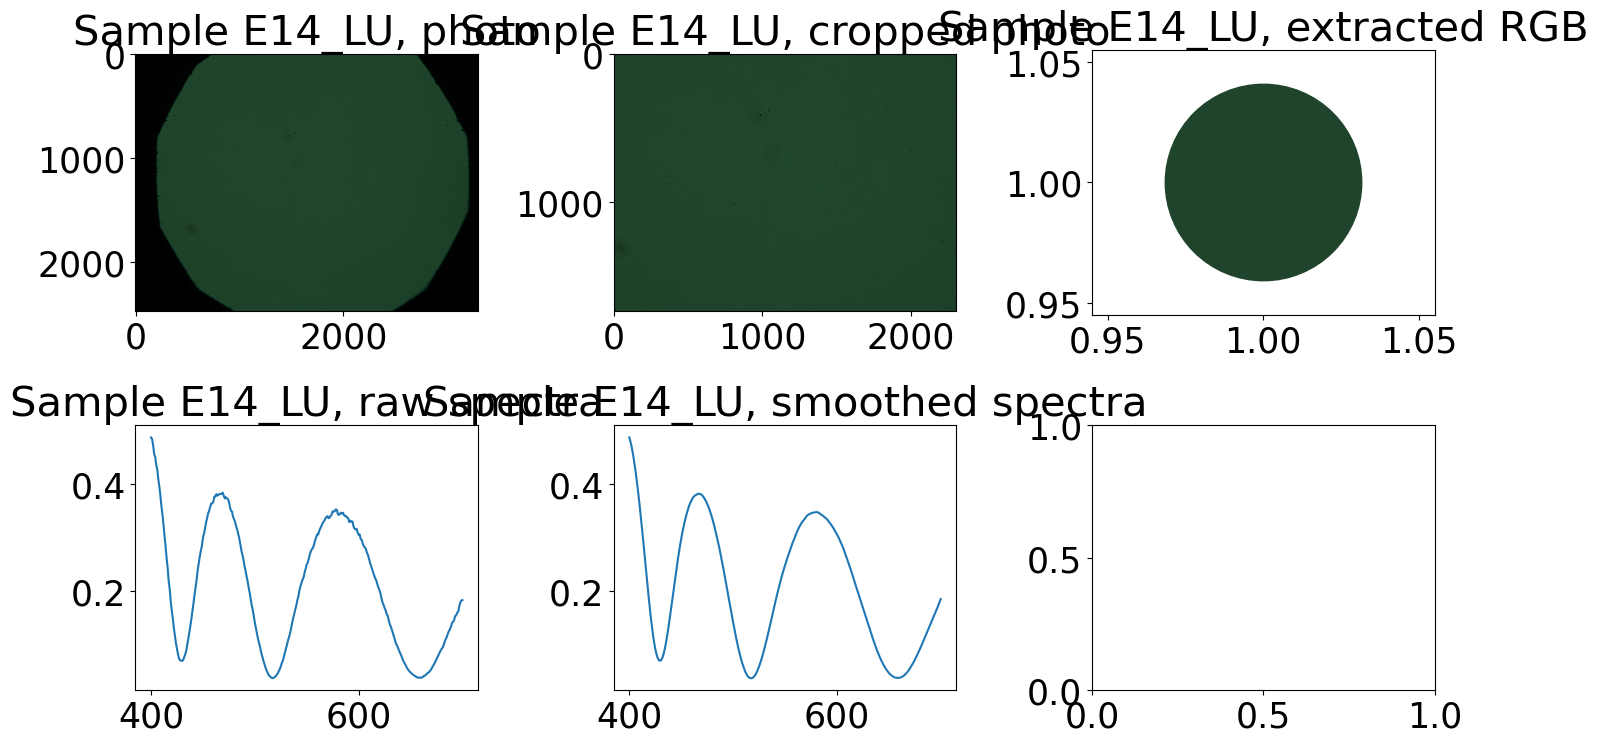

In [6]:
# Show all data for a random sample
ran_sam = np.random.choice(sample_list)
ran_sam=sample_list[-1]
# ran_sam= sample_list[20]
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0, 0].imshow(ran_sam.raw_photo / 2 ** 14)
ax[0, 0].set_title("Sample {}, photo".format(ran_sam.name))
ax[0, 1].imshow(ran_sam.get_cropped_photo() / 2 ** 14)
ax[0, 1].set_title("Sample {}, cropped photo".format(ran_sam.name))
ax[0, 2].scatter(1, 1, color=ran_sam.get_RGB() / 2 ** 14, s=20000)
ax[0, 2].set_title("Sample {}, extracted RGB".format(ran_sam.name))
ax[1, 0].plot(lams, ran_sam.raw_spectra)
ax[1, 0].set_title("Sample {}, raw spectra".format(ran_sam.name))
ax[1, 1].plot(lams, ran_sam.get_smooth_spectra())
ax[1, 1].set_title("Sample {}, smoothed spectra".format(ran_sam.name))
plt.tight_layout()
plt.show()

## Define basis functions

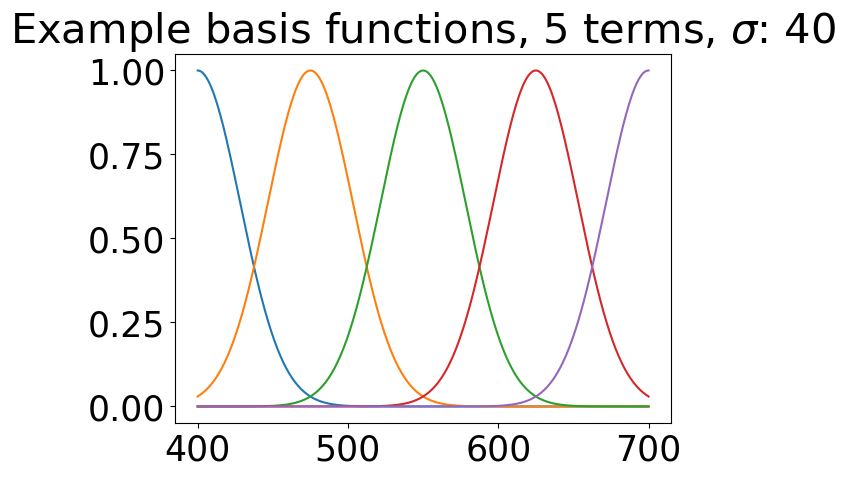

In [7]:
def base_n(n_terms, n, sigma, lams):
    """ Returns a gaussian centered at lam_vec[n], where lam_vec is a vector that
        containing equispaced wavelengths inside the visible range
        
        Arguments:
            - n_terms [int]: Number of divisions of the visible
            - n [int]: Index of the central wavelength of the gaussian
            - sigma [float]: Controls the width of the gaussian
            - lams [1D array]: Wavelenghts comprising the visible
    """
    # Obtain central wavelengths of gaussians
    lamstart = lam0
    lamend = lamf
    lami = np.linspace(lamstart, lamend, n_terms)

    return np.exp(-((lams - lami[n]) ** 2) / sigma ** 2)


n_terms = 5
sigma = 40
plt.figure()
for q in range(n_terms):
    plt.plot(lams, base_n(n_terms, q, sigma, lams))
    plt.title("Example basis functions, {} terms, $\sigma$: {}".format(n_terms, sigma))

# Perform regression and recover CMFs

## Split samples into training and validation sets

In [8]:
sam_no = len(sample_list)
train_no = int(sam_no * train_percent)
val_no = sam_no - train_no

print(
    "From {} samples, using {} for training and {} for validation".format(
        sam_no, train_no, val_no
    )
)
idx_vec = np.random.permutation(np.arange(sam_no))

train_list = sample_list[idx_vec[:train_no]]
val_list = sample_list[idx_vec[train_no:]]

From 65 samples, using 48 for training and 17 for validation


## Define recovery and scoring functions for the CMFs

In [9]:
def mse(vecA, vecB):
    """ Computes the mean square error between two 1D vectors"""
    return 1 / vecA.size * np.sum((vecA - vecB) ** 2)


def recover_CMFs(spectra_vec, rgb_vec, n_terms, sig, plot=False):
    """ Computes the CMFs for a sample set and basis function parameters, optionally plots them.
        Arguments:
            - spectra_vec [1D array]: An array in which each element is the spectra of a sample
            - rgb_vec [1D array]: An array in which each element is the true rgb triplet of a sample
            - n_terms [int]: Number of basis functions to use
            - sig [float]: Sigma of the gaussians
        
        Returns:
         - RCMF, GCMF, BCMG [tuple of 1D arrays]: The CMFs that best recover the measured colors from the measured spectra
            
    """
    # Number of samples
    samples_no = spectra_vec.shape[0]

    # Allocate A matrix
    A = np.zeros([samples_no, n_terms])

    # Compute A matrix rows
    for q in range(samples_no):
        A[q, :] = [
            np.trapz(spectra_vec[q] * base_n(n_terms, n, sig, lams), lams)
            for n in range(n_terms)
        ]

    # Perform regression analysis on each channel
    # solR = scipy.optimize.nnls(A, rgb_vec[:, 0])
    # solG = scipy.optimize.nnls(A, rgb_vec[:, 1])
    # solB = scipy.optimize.nnls(A, rgb_vec[:, 2])
    solR = scipy.optimize.lsq_linear(A, rgb_vec[:, 0])
    solG = scipy.optimize.lsq_linear(A, rgb_vec[:, 1])
    solB = scipy.optimize.lsq_linear(A, rgb_vec[:, 2])

    # Recover expansion coefficients
    # coeffsR = solR[0]
    # coeffsG = solG[0]
    # coeffsB = solB[0]
    coeffsR = solR.x
    coeffsG = solG.x
    coeffsB = solB.x

    # Allocate CMFs vectors
    RCMF = 0 * base_n(n_terms, 0, sig, lams)
    GCMF = RCMF.copy()
    BCMF = RCMF.copy()

    # Create CMFs
    for n in range(n_terms):
        RCMF += coeffsR[n] * base_n(n_terms, n, sigma, lams)
        GCMF += coeffsG[n] * base_n(n_terms, n, sigma, lams)
        BCMF += coeffsB[n] * base_n(n_terms, n, sigma, lams)

    if plot:
        plt.figure()
        plt.plot(lams, RCMF, c="red", label="$r(\lambda)$")
        plt.plot(lams, GCMF, c="green", label="$g(\lambda)$")
        plt.plot(lams, BCMF, c="blue", label="$b(\lambda)$")
        plt.title("Recovered CMFs, terms: {}, $\sigma$={}".format(n_terms, sig))
        plt.xlabel("wavelength [nm]")
        plt.ylabel("Intensity")
        plt.show()

    return RCMF, GCMF, BCMF


def spec2rgb(spectra, RCMF, GCMF, BCMF):
    """ Computes the RGB triplet corresponding to a spectra using a set of CMFs
        Args:
            - Spectra [1D array]: Intensity values of the spectra to convert
            - RCMF [1D array]: Intensity values of the red CMF
            - GCMF [1D array]: Intensity values of the green CMF
            - BCMF [1D array]: Intensity values of the blue CMF
        
        Returns:
            - RGB [1D array]: Array containing the recovered RGB values in 0-1 scale
    """
    rgb = (
        np.array(
            [
                np.trapz(spectra * RCMF),
                np.trapz(spectra * GCMF),
                np.trapz(spectra * BCMF),
            ]
        )
        / 2 ** 14
    )
    rgb[rgb > 1] = 1
    return rgb


def avg_recovery_mse(spectra_vec, true_rgb_vec, RCMF, GCMF, BCMF, plot=False):
    """ Computes the average mse between the measured RGB values and the CMFs recovered values for a set of samples, optionally plots
    the true vs recovered colors
        Args:
            - spectra_vec [1D array] - An array in which each element is the spectra of a sample
            - true_rgb_vec [1D array] - An array in which each element is the true rgb triplet of a sample
            - RCMF [1D array]: Intensity values of the red CMF
            - GCMF [1D array]: Intensity values of the green CMF
            - BCMF [1D array]: Intensity values of the blue CMF
    """
    rec_rgb_vec = np.array(
        [spec2rgb(spectra, RCMF, GCMF, BCMF) for spectra in spectra_vec]
    )
    mse_vec = np.array(
        [
            mse(true_rgb_vec[k] / 2 ** 14, rec_rgb_vec[k])
            for k in range(true_rgb_vec.shape[0])
        ]
    )

    if plot:
        plt.figure(figsize=(30, 6))
        plt.bar(np.arange(true_rgb_vec.shape[0]) + 1, mse_vec)
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.xticks(rotation=270)
        plt.title(
            "MSE TrueRGB vs recovered RGB. AVG = {:.3E}, STD={:.3E}".format(mse_vec.mean(),mse_vec.std()),
            fontsize=20,
        )
        plt.hlines(
            mse_vec.mean(), 0, true_rgb_vec.shape[0], color="red", label="Average"
        )
        plt.xlabel("Sample")
        plt.grid(True, linestyle="--")
        plt.legend()

        plt.figure(figsize=(true_rgb_vec.shape[0], 6))
        true_cols = true_rgb_vec / 2 ** 14
        rec_cols = rec_rgb_vec
        rec_cols[rec_cols > 1] = 1
        rec_cols[rec_cols < 0] = 0
        plt.scatter(
            np.arange(true_rgb_vec.shape[0]) + 1,
            np.zeros(true_rgb_vec.shape[0]),
            c=true_cols,
            s=2000,
        )
        plt.scatter(
            np.arange(true_rgb_vec.shape[0]) + 1,
            0.1 * np.ones(true_rgb_vec.shape[0]),
            c=rec_cols,
            s=2000,
        )
        plt.text(true_rgb_vec.shape[0] / 2, -0.05, "Measured")
        plt.text(true_rgb_vec.shape[0] / 2, 0.15, "Recovered")
        plt.gca().axison = False

        plt.ylim(-0.15, 0.2)
    return mse_vec.mean()

## Example recovery and testing

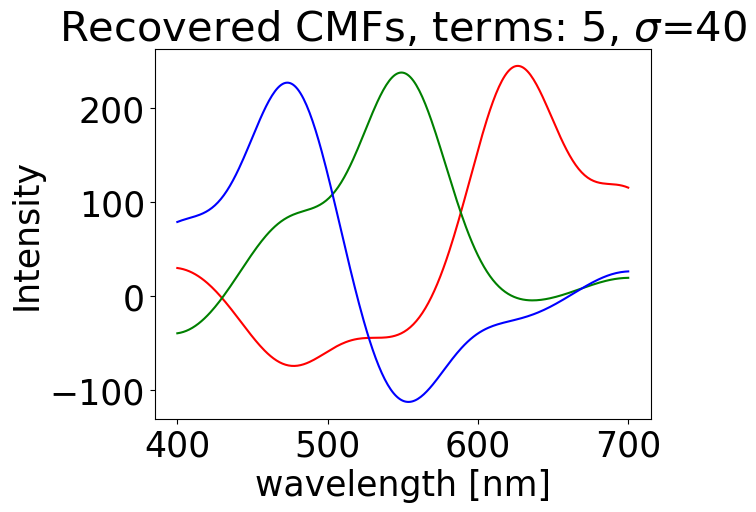

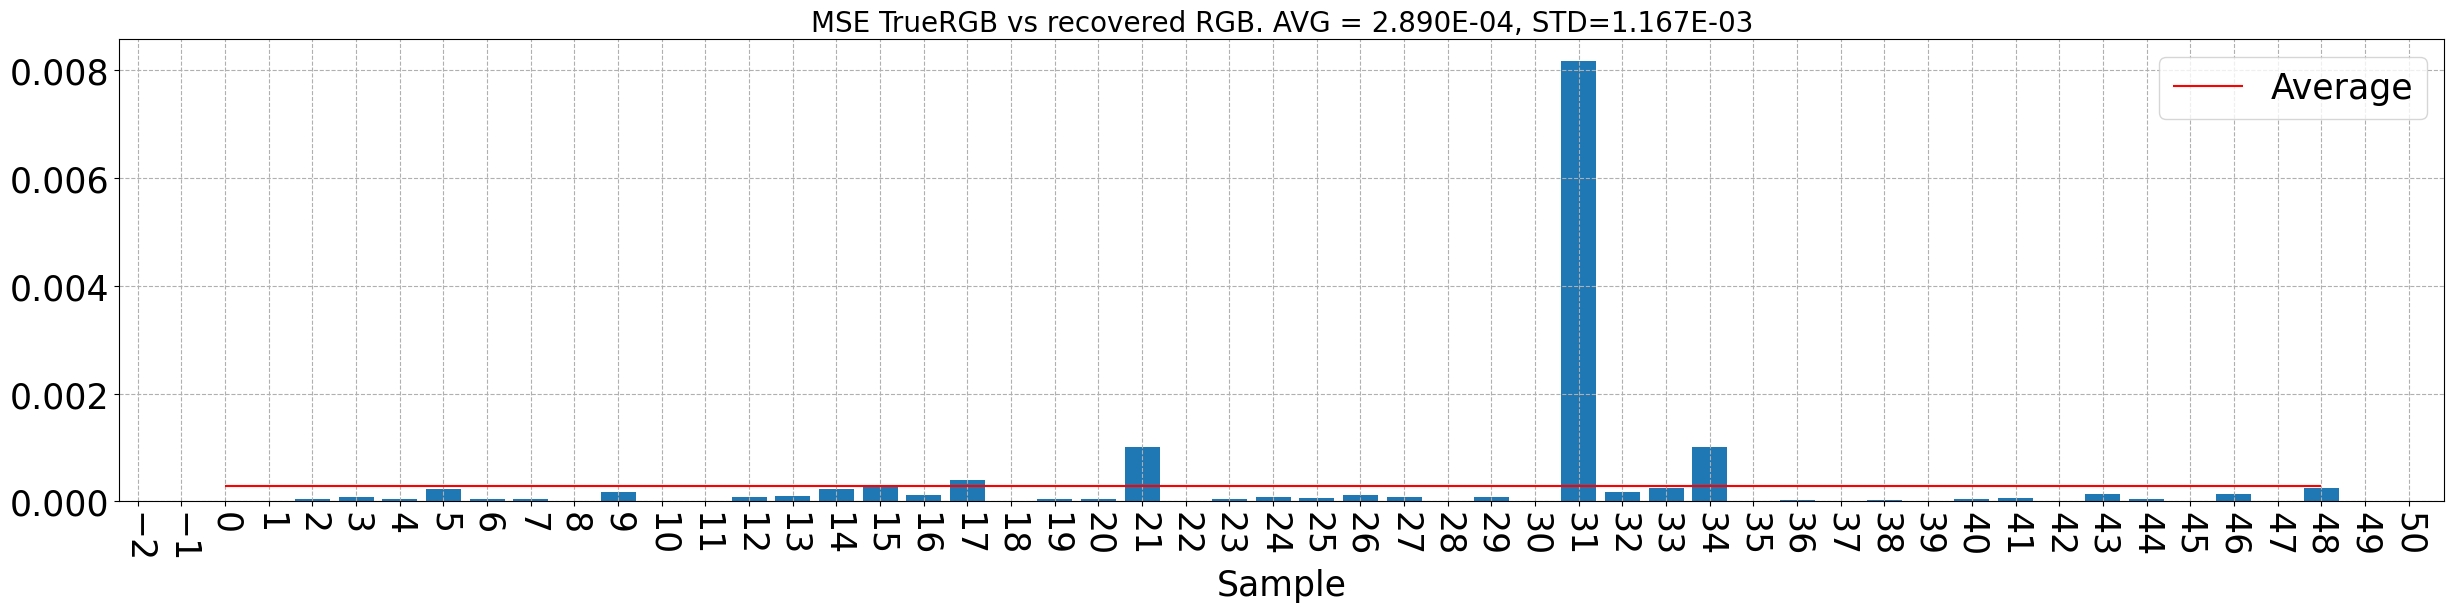

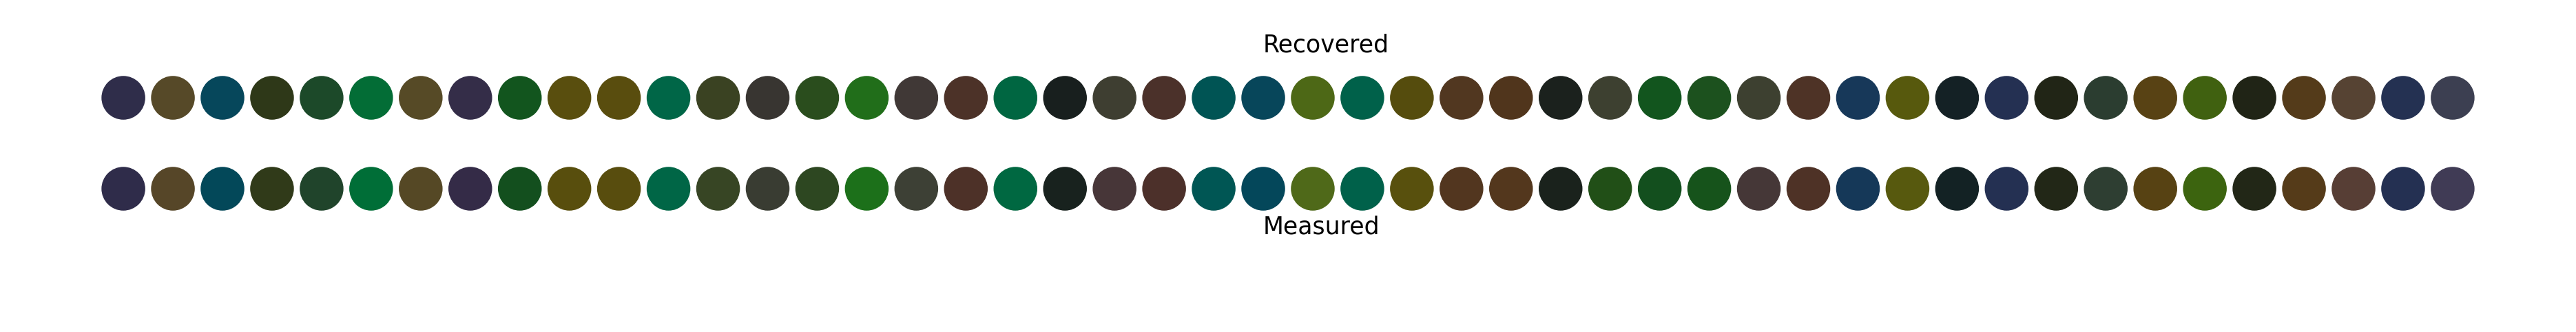

In [10]:
train_spectra = np.array([sample.get_smooth_spectra() for sample in train_list])
train_rgb = np.array([sample.get_RGB() for sample in train_list])

RCMF, GCMF, BCMF = recover_CMFs(train_spectra, train_rgb, 5, 40, plot=True)
example_mse = avg_recovery_mse(train_spectra, train_rgb, RCMF, GCMF, BCMF, plot=True)

# Finding the optimal CMFs

The following code finds the optimal number of modes and gaussian function shapes for the CMFs to minimize the recovered vs measured colors error of the validation tamples. 

In [11]:
# Create multiprocessing pool (Do not run on linux)
# import multiprocess as mp
# from itertools import product
# p=mp.Pool(mp.cpu_count())

In [12]:
# Search limits
n_lims = (4, 12)
sig_lims = (10, 80)

# Create search vectors
n_terms_vec = np.arange(n_lims[0], n_lims[1] + 1)
sig_lims_vec = np.arange(sig_lims[0], sig_lims[1], 0.1)

# Allocate mse matrix
mse_mat = np.zeros((n_terms_vec.size, sig_lims_vec.size))

# Extract validation samples spectra and measured RGB
val_spectra = np.array([sample.get_smooth_spectra() for sample in train_list])
val_rgb = np.array([sample.get_RGB() for sample in train_list])

In [13]:
# === Parallel computation with multiprocess module (Do not run on linux) === #

# # Define the mse optimization function
# def val_mse(n_terms,sig):
#     RCMF, GCMF, BCMF=recover_CMFs(train_spectra,train_rgb,n_terms,sig,plot=False)
#     return avg_recovery_mse(val_spectra,val_rgb, RCMF, GCMF, BCMF, plot=False)

# # Compute the average mse for all combinations of n_terms and sigma
# for k,sig in enumerate(tqdm(sig_lims_vec)):
#     mvec=p.starmap_async(val_mse,product(n_terms_vec,[sig]))
#     mse_mat[:,k]=mvec.get()

In [14]:
# === Parallel computation with joblib module (Only linux) === #


def par_mse(sig):
    RCMF, GCMF, BCMF = recover_CMFs(train_spectra, train_rgb, n_terms, sig, plot=False)
    return avg_recovery_mse(val_spectra, val_rgb, RCMF, GCMF, BCMF, plot=False)


for k, n_terms in enumerate(tqdm(n_terms_vec)):
    train_no = int(sam_no * train_percent)
    val_no = sam_no - train_no
    train_spectra = np.array([sample.get_smooth_spectra() for sample in train_list])
    train_rgb = np.array([sample.get_RGB() for sample in train_list])
    mse_mat[k, :] = Parallel(n_jobs=-1)(delayed(par_mse)(sig) for sig in sig_lims_vec)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


## Show optimization results

Best found number of terms: 12, sigma:39.99999999999989m avg validation mse:0.00023623899085137604


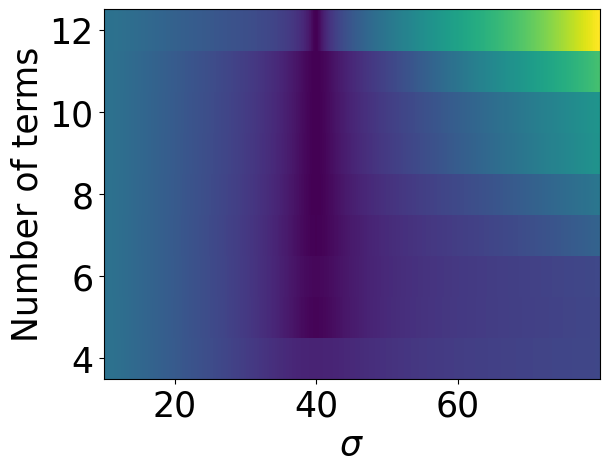

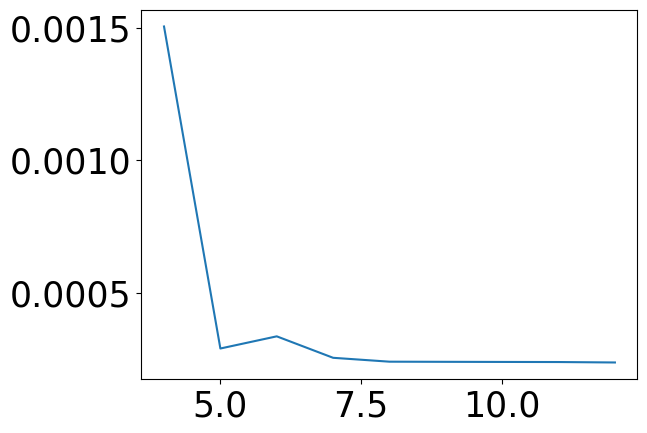

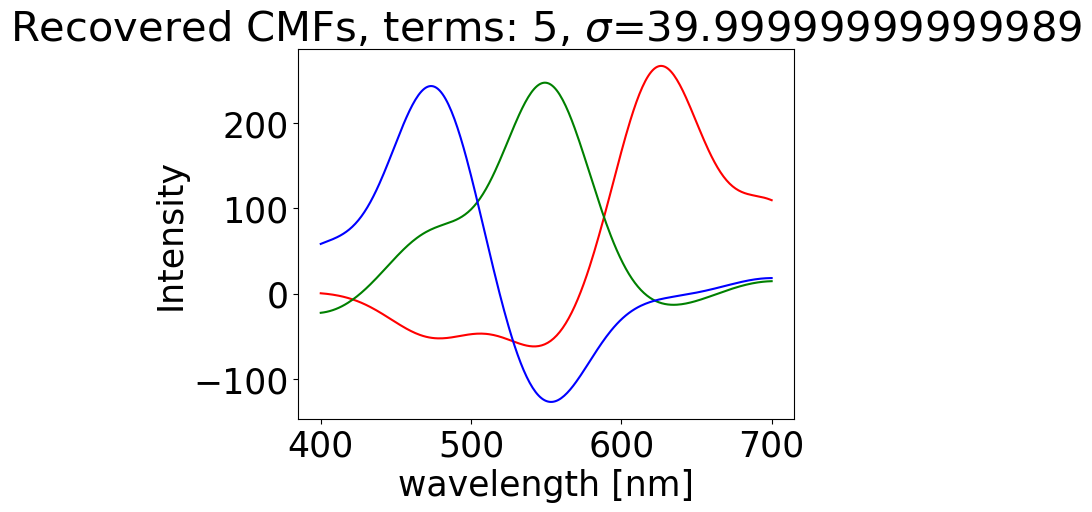

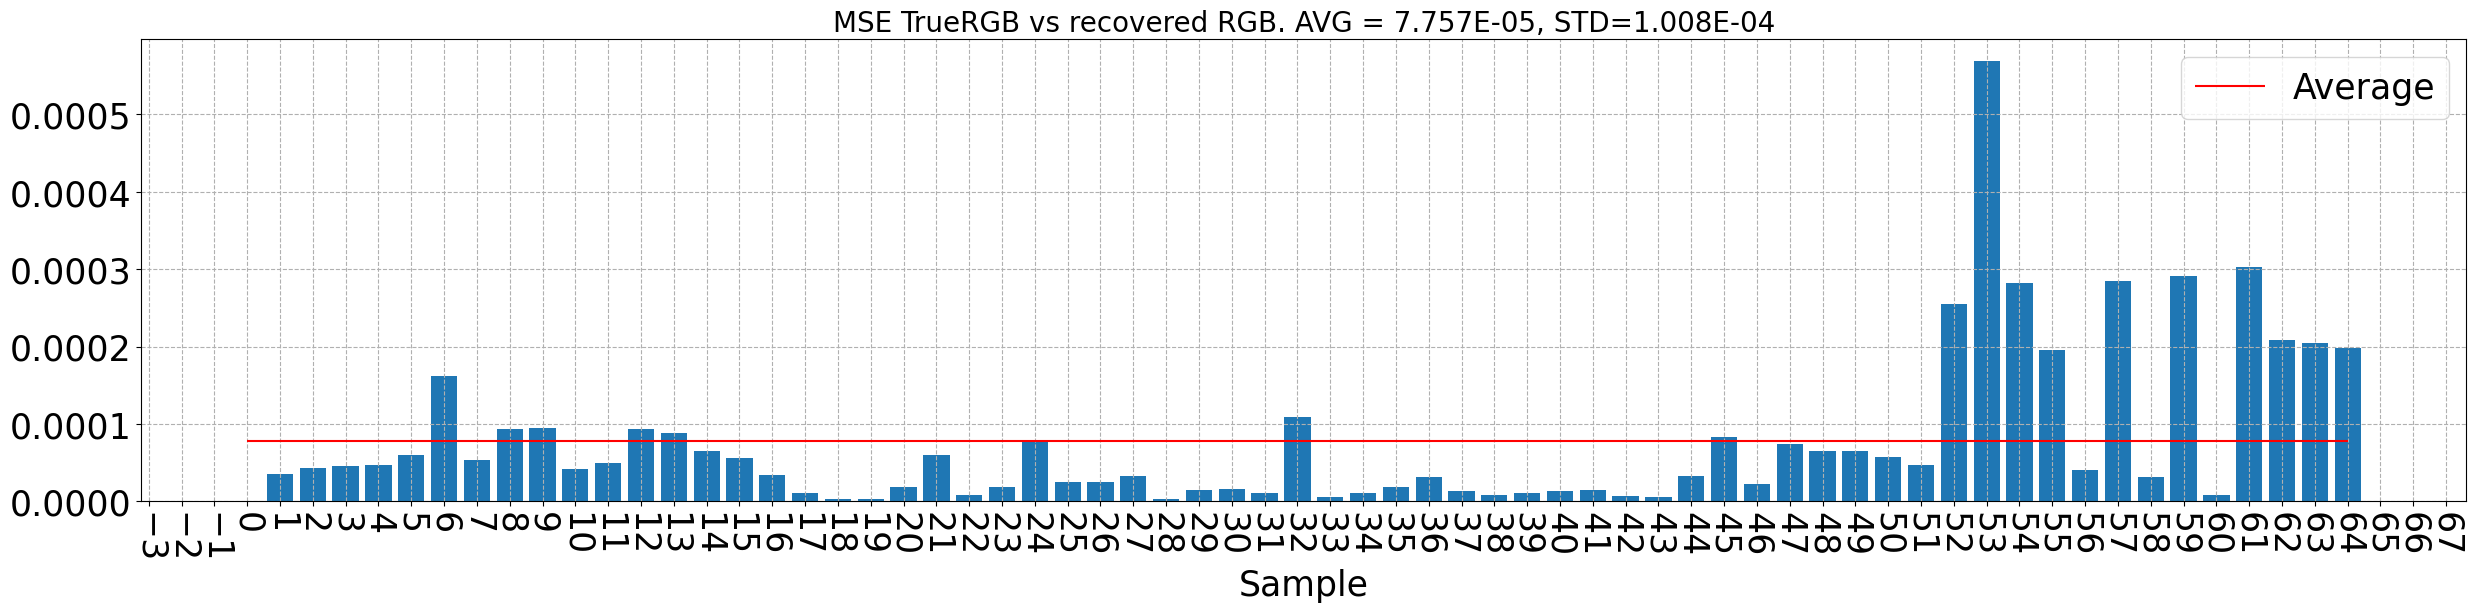

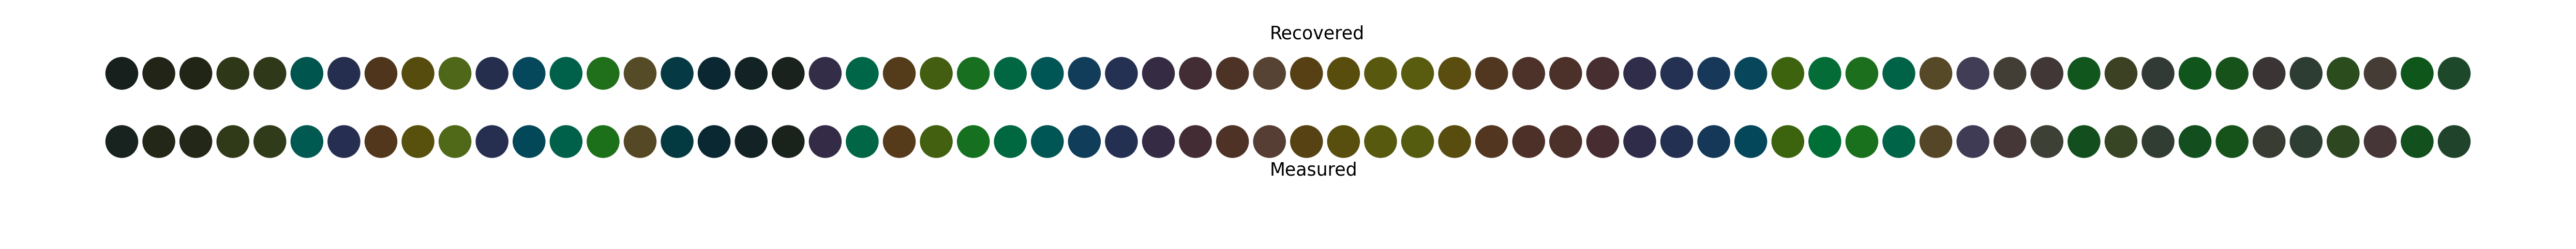

In [15]:
plt.pcolor(sig_lims_vec, n_terms_vec, np.log10(mse_mat), shading="auto")
plt.xlabel("$\sigma$")
plt.ylabel("Number of terms")


idx = np.unravel_index(np.argmin(mse_mat, axis=None), mse_mat.shape)
best_n_terms = n_terms_vec[idx[0]]
best_sigma = sig_lims_vec[idx[1]]

# best_n_terms=100

print(
    "Best found number of terms: {}, sigma:{}m avg validation mse:{}".format(
        best_n_terms, best_sigma, mse_mat.min()
    )
)

plt.figure()
plt.plot(n_terms_vec, mse_mat[:, idx[1]])

# Note: E1_LU is an atypical sample, we remove it
all_spectra = np.array([sample.get_smooth_spectra() for sample in sample_list if sample.name!='E1_LU'])
all_rgb = np.array([sample.get_RGB() for sample in sample_list if sample.name!='E1_LU'])


# RCMF, GCMF, BCMF = recover_CMFs(
#     train_spectra, train_rgb, best_n_terms, best_sigma, plot=True
# )

best_n_terms=5

RCMF, GCMF, BCMF = recover_CMFs(
    all_spectra, all_rgb, best_n_terms, best_sigma, plot=True
)

# Plot recovered vs real colors
_ = avg_recovery_mse(all_spectra, all_rgb, RCMF, GCMF, BCMF, plot=True)

# Save results for next notebook

In [16]:
# Save CFMS
np.save("v5_CCD_CMFs_lu.npy", np.array([lams, RCMF, GCMF, BCMF]).transpose())

# Save processed spectra
np.save("v5_sam_spectra_lu.npy", all_spectra)

# Save RGB list
np.save("v5_sam_rgb_lu.npy", all_rgb)

# Results

7.75e-5 for LU, 3.802e-3 for LD with 5 terms, sigma=40